In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import imageio

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def ResNet_two_blocks(U1, V1, U2, V2, x, y):
    # First residual block
    hidden1 = torch.relu(torch.sum(V1 * x[:, None, :], dim=2))
    output1 = x + torch.sum(U1 * hidden1[:, None, :], dim=2)  # output_1 = x + U_1 σ(V_1 x)

    # Second residual block
    hidden2 = torch.relu(torch.sum(V2 * output1[:, None, :], dim=2))
    output2 = output1 + torch.sum(U2 * hidden2[:, None, :], dim=2)  # output_2 = output_1 + U_2 σ(V_2 output_1)

    # Loss calculation
    loss = torch.sum((output2 - y) ** 2)
    return loss

def compute_dim_grad(batch_size, input_size, hidden_size1, hidden_size2):
    param_dimension = 2*(input_size * hidden_size1) + 2*(input_size * hidden_size2)
    upper_bound = param_dimension - hidden_size1 - hidden_size2
    x = torch.randn(batch_size, input_size, device=device).double()
    y = torch.randn(batch_size, input_size, device=device).double()

    V1_ = torch.randn(hidden_size1, input_size, device=device).double()
    V1 = V1_.unsqueeze(0).repeat(batch_size, 1, 1).requires_grad_(True)
    U1_ = torch.randn(input_size, hidden_size1, device=device).double()
    U1 = U1_.unsqueeze(0).repeat(batch_size, 1, 1).requires_grad_(True)
    V2_ = torch.randn(hidden_size2, input_size, device=device).double()
    V2 = V2_.unsqueeze(0).repeat(batch_size, 1, 1).requires_grad_(True)
    U2_ = torch.randn(input_size, hidden_size2, device=device).double()
    U2 = U2_.unsqueeze(0).repeat(batch_size, 1, 1).requires_grad_(True)

    loss = ResNet_two_blocks(U1, V1, U2, V2, x, y)
    loss.backward()

    gradient_matrix = torch.cat([V1.grad.view(batch_size, -1), U1.grad.view(batch_size, -1),
                                  V2.grad.view(batch_size, -1), U2.grad.view(batch_size, -1)], axis=1)
    #S = np.linalg.svd(gradient_matrix.cpu().numpy(), compute_uv=False)
    #lS = np.log10(S)
    #plt.plot(lS, '.')
    #plt.plot( [upper_bound - 1, upper_bound - 1], [min(lS),max(lS)], 'r:' )
    # Zero out the gradients
    U1.grad.zero_()
    V1.grad.zero_()
    U2.grad.zero_()
    V2.grad.zero_()
    return np.linalg.matrix_rank(gradient_matrix.cpu().numpy())

# Exemple d'utilisation
batch_size = 100000
input_size = 3
hidden_size1 = 50
hidden_size2 = 20
param_dimension = 2*(input_size * hidden_size1) + 2*(input_size * hidden_size2)

rank = compute_dim_grad(batch_size, input_size, hidden_size1, hidden_size2)
print("Rank of the gradient matrix:", rank)
print("expected:", param_dimension - hidden_size1 - hidden_size2)

Rank of the gradient matrix: 350
expected: 350


In [5]:
import numpy as np
from joblib import Parallel, delayed

# Number of trials
N_TRIALS = 100

# Parameter ranges
input_size_list = list(range(1, 14, 3))
hidden_size_list = list(range(1, 14, 3))

def compute_single_trial(batch_size, input_size, hidden_size1, hidden_size2):
    """
    Compute a single trial and return if the condition is satisfied.
    """
    param_dimension = 2 * (input_size * hidden_size1) + 2 * (input_size * hidden_size2)
    upper_bound = param_dimension - hidden_size1 - hidden_size2
    estimated_value = compute_dim_grad(
        batch_size=batch_size,
        input_size=input_size,
        hidden_size1=hidden_size1,
        hidden_size2=hidden_size2
    )  # Assumes compute_dim_grad is implemented
    return float(upper_bound == estimated_value)


xp_results = np.zeros((len(input_size_list), len(hidden_size_list), N_TRIALS))

# Parallelize over input_size and hidden_size
for i, input_size in enumerate(input_size_list):
    for j, hidden_size in enumerate(hidden_size_list):
        param_dimension = 4 * (input_size * hidden_size)
        batch_size = 100000
        # Use joblib to parallelize trials
        results = Parallel(n_jobs=-1)(
            delayed(compute_single_trial)(
                    batch_size, input_size, hidden_size, hidden_size
                ) for _ in range(N_TRIALS)
            )
        xp_results[i, j, :] = results
        print(f"Completed input_size={input_size}, hidden_size={hidden_size}")

    # Compute probabilities
    xp_probas = np.mean(xp_results, axis=-1)
    #map_batch_size.append(xp_probas)

Completed input_size=1, hidden_size=1
Completed input_size=1, hidden_size=4
Completed input_size=1, hidden_size=7
Completed input_size=1, hidden_size=10
Completed input_size=1, hidden_size=13
Completed input_size=4, hidden_size=1
Completed input_size=4, hidden_size=4
Completed input_size=4, hidden_size=7
Completed input_size=4, hidden_size=10
Completed input_size=4, hidden_size=13
Completed input_size=7, hidden_size=1
Completed input_size=7, hidden_size=4
Completed input_size=7, hidden_size=7
Completed input_size=7, hidden_size=10
Completed input_size=7, hidden_size=13
Completed input_size=10, hidden_size=1
Completed input_size=10, hidden_size=4
Completed input_size=10, hidden_size=7
Completed input_size=10, hidden_size=10
Completed input_size=10, hidden_size=13
Completed input_size=13, hidden_size=1
Completed input_size=13, hidden_size=4
Completed input_size=13, hidden_size=7
Completed input_size=13, hidden_size=10
Completed input_size=13, hidden_size=13


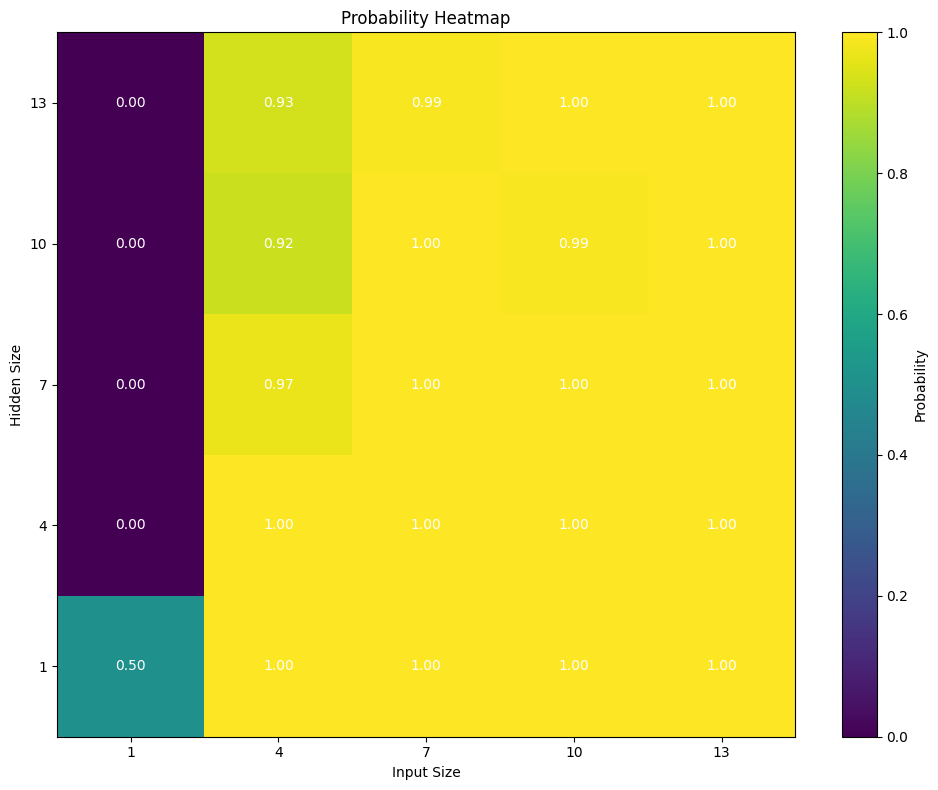

In [6]:
# Assuming you have already calculated xp_probas

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 8))

# Create the heatmap
im = ax.imshow(xp_probas.T, cmap='viridis', aspect='auto', origin='lower')

# Set the ticks and labels for x and y axes
ax.set_xticks(range(len(input_size_list)))
ax.set_yticks(range(len(hidden_size_list)))
ax.set_xticklabels(input_size_list)
ax.set_yticklabels(hidden_size_list)

# Set labels and title
ax.set_xlabel('Input Size')
ax.set_ylabel('Hidden Size')
ax.set_title('Probability Heatmap')

# Add colorbar
cbar = fig.colorbar(im)
cbar.set_label('Probability')

# Add text annotations to show the probability values
for i in range(len(input_size_list)):
    for j in range(len(hidden_size_list)):
        text = ax.text(i, j, f"{xp_probas[i, j]:.2f}",
                       ha="center", va="center", color="w")

plt.tight_layout()
plt.show()